# Non-Stationary Kernels
This tutorial will walk you through using non-stationary kernels within the `sgptools` library. Standard kernels, like the Radial Basis Function (RBF), are "stationary," meaning they assume the data's characteristics (like smoothness and variance) are the same everywhere. This is often not true for real-world environmental data, which can have different patterns in different areas.

**Non-stationary kernels** are more flexible because they can adapt to these local changes. This often leads to more accurate models and better decision-making in tasks like Sensor Placement and Informative Path Planning.

In this tutorial, we will:
1.  **Generate synthetic non-stationary data** to simulate a complex environment.
2.  **Train and compare three different kernels**:
    * **RBF**: A standard stationary kernel, which will serve as our baseline for comparison.
    * **Attentive**: Another non-stationary kernel that uses an attention mechanism to focus on relevant data features.
    * **Neural Spectral**: A powerful non-stationary kernel that uses a neural network to learn the spatial properties of the data.
3.  **Use these kernels for a sensor placement task** using the `ContinuousSGP` method.
4.  **Visualize and evaluate** how well each kernel performs.

Let's get started!

## Setup and Imports

We begin by importing the necessary libraries and modules.
- `os`: Used to set environment variables to avoid potential conflicts with underlying libraries.
- `numpy`: For numerical operations.
- `tensorflow`: The backend for GPflow.
- `matplotlib.pyplot`: For plotting the results.
- `sgptools` modules: We import specific classes and functions from the library that we'll be using.

In [ ]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ["QT_QPA_PLATFORM"] = "offscreen"

from sklearn.preprocessing import StandardScaler
from gpflow.utilities.traversal import deepcopy
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import gpflow
gpflow.config.set_default_float(np.float32)

from sgptools.methods import ContinuousSGP
from sgptools.utils.misc import get_inducing_pts, cont2disc
from sgptools.kernels import get_kernel
from sgptools.utils.gpflow import get_model_params, optimize_model

# Set random seeds for reproducibility
np.random.seed(1234)
tf.random.set_seed(1234)

## Generate Synthetic Non-Stationary Data
To properly test our non-stationary kernels, we need data that exhibits non-stationary behavior. We'll create a synthetic dataset where the spatial patterns change across the map. Our function `non_stationary_function` combines two different sinusoidal patterns, creating distinct regions with different characteristics.

Train Data: (800, 2) (800, 1)
Test Data: (5000, 2) (5000, 1)


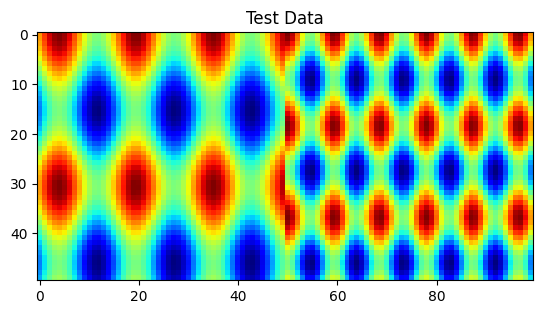

In [2]:
def non_stationary_function(X, Y):
    Z1 = np.sin(X/10) + np.cos(Y/10)
    Z2 = np.cos(X/6) + np.cos(Y/6)
    Z = np.concatenate([Z1[:, ::2], Z2[:, ::2]], 
                       axis=1)
    return Z

# Generate the training and testing data grids
train_data_dims = (40, 20)
x = np.linspace(0, 200, train_data_dims[0])
y = np.linspace(0, 100, train_data_dims[1])
X, Y = np.meshgrid(x, y)
Z = non_stationary_function(X, Y)

# Flatten the grid data into a list of (x, y) coordinates and corresponding values
X_train = np.stack([X.ravel(), Y.ravel()], 
                   axis=1).astype(np.float32)
Y_train = Z.ravel()[:, None].astype(np.float32)
print('Train Data:', X_train.shape, Y_train.shape)

# Generate a higher-resolution grid for testing our model's predictions
test_data_dims = (100, 50)
x = np.linspace(0, 200, test_data_dims[0])
y = np.linspace(0, 100, test_data_dims[1])
X, Y = np.meshgrid(x, y)
Z = non_stationary_function(X, Y)

X_test = np.stack([X.ravel(), Y.ravel()], 
                  axis=1).astype(np.float32)
Y_test = Z.ravel()[:, None].astype(np.float32)
print('Test Data:', X_test.shape, Y_test.shape)

# Normalize the data: This is a standard practice in machine learning that helps
# optimization algorithms converge faster and more reliably.
Xscalar = StandardScaler()
X_train = Xscalar.fit_transform(X_train)
X_test = Xscalar.transform(X_test)

yScalar = StandardScaler()
Y_train = yScalar.fit_transform(Y_train)
Y_test = yScalar.transform(Y_test)

# Plot the training and testing data to visualize the non-stationary patterns
plt.figure()
plt.imshow(Y_test.reshape(test_data_dims[1], 
                          test_data_dims[0]), 
           cmap='jet')
plt.gca().set_aspect('equal')
plt.title('Test Data')
plt.show()

## Learning Kernel Parameters
Now, we'll train each of our three kernels on the training data. The goal is for each kernel to learn the underlying spatial structure of the environment. We expect the non-stationary kernels to perform better at this task, given the nature of our data.

We'll store the trained kernels and their corresponding noise variances in lists

In [3]:
kernels = []
noice_vars = []
labels = []

## Stationary RBF Kernel (Our Baseline)
The RBF kernel is a standard choice for GP models. It's a stationary kernel, meaning it assumes the data's properties are the same everywhere. It will serve as a good baseline to see how much of an advantage the non-stationary kernels provide.

In [ ]:
_, noise_variance, kernel = get_model_params(
    X_train=X_train, y_train=Y_train, 
    kernel=get_kernel('RBF')(),
    optimizer='scipy.L-BFGS-B',
)

kernels.append(kernel)
noice_vars.append(noise_variance)
labels.append('RBF')

##  Non-Stationary Attentive Kernel
The Attentive Kernel uses a neural network to learn "attention weights" for a mixture of standard RBF kernels. This allows it to decide which RBF kernel (with its specific lengthscale) is most important for modeling the data at a particular location.

In [ ]:
_, noise_variance, kernel = get_model_params(
    X_train=X_train, y_train=Y_train, 
    kernel=get_kernel('Attentive')(),
    optimizer='tf.Nadam',
    learning_rate=1e-2,
    max_steps=3000)

kernels.append(kernel)
noice_vars.append(noise_variance)
labels.append('Attentive')

## Non-Stationary Neural Spectral Kernel

The Neural Kernel is a highly expressive model that uses a small neural network to learn the parameters of a spectral mixture kernel at every point. This allows it to adapt to very complex spatial patterns.

In [ ]:
_, noise_variance, kernel = get_model_params(
    X_train=X_train, y_train=Y_train, 
    kernel=get_kernel('NeuralSpectral')(Q=5, 
                                        hidden_sizes=[4, 4]),
    optimizer='tf.Nadam',
    learning_rate=1e-2,
    max_steps=3000)

kernels.append(kernel)
noice_vars.append(noise_variance)
labels.append('Neural Spectral')

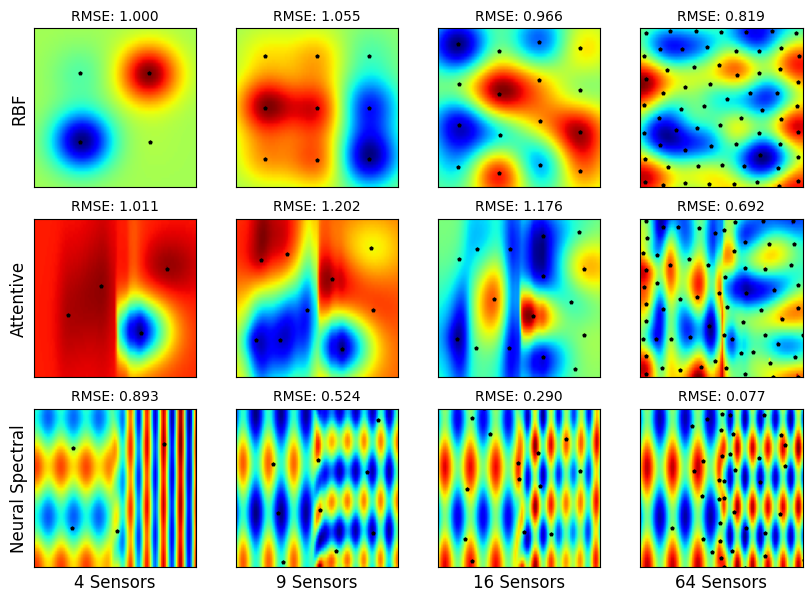

In [7]:
num_placements_list = [4, 9, 16, 64] # Number of sensor placements to evaluate

# Setup the matplotlib figure for plotting results
fig, axs = plt.subplots(len(kernels), len(num_placements_list), figsize=(10, 7))
# Iterate through each trained kernel and its corresponding noise variance
for i, (kernel, noice_var) in enumerate(zip(kernels, noice_vars)):
    for j, num_placements in enumerate(num_placements_list):
        # Get initial inducing points for the ContinuousSGP optimization
        # These will be the initial sensor locations.
        Xu_init = get_inducing_pts(X_train, num_placements)
        Xu_init = Xu_init.astype(np.float32) # Ensure data type consistency

        # Setup ContinuousSGP model
        # ContinuousSGP takes X_objective as the data for the SGPR model,
        # and Xu_init is passed as the initial inducing_variable.
        csgp_method = ContinuousSGP(
            num_sensing=num_placements, 
            X_objective=X_train, # Use X_train as the objective points for SGP
            kernel=kernel, # Pass the trained kernel
            noise_variance=noice_var, # Pass the trained noise variance
            X_init=Xu_init # Initial inducing points
        )

        # Optimize the ContinuousSGP model to find solution sensor placements
        # The optimize method returns the optimized inducing points (sensor locations).
        # It reshapes the solution to (num_robots, num_sensing, num_dim) but here num_robots=1
        # so we flatten it back to (num_sensing, num_dim).
        sgp_sol_reshaped = csgp_method.optimize(max_steps=500, verbose=0) # Run optimization
        sgp_sol_sp = sgp_sol_reshaped.reshape(-1, X_train.shape[1])


        # To evaluate the performance of the sensor placements,
        # we will simulate taking measurements at the optimized locations
        sol_X, sol_y = cont2disc(sgp_sol_sp, 
                                 candidates=X_test,
                                 candidate_labels=Y_test)
        
        # Create a GP model to reconstruct the data field from the gathered sensor data
        _, _, _, model = get_model_params(
            sol_X, sol_y, max_steps=0, return_model=True,
            kernel=kernel, 
            noise_variance=noice_var,
            verbose=False
        )
        y_pred, y_var = model.predict_f(X_test)
        y_pred = y_pred.numpy()

        # Calculate the Root Mean Square Error (RMSE) to quantify the reconstruction accuracy
        rmse = np.sqrt(np.mean((y_pred - Y_test)**2))

        # Plot the results
        axs[i, j].imshow(y_pred.reshape(test_data_dims[1], test_data_dims[0]),
                         cmap='jet', origin='lower',
                         extent=[np.min(X_test[:, 0]), np.max(X_test[:, 0]),
                                 np.min(X_test[:, 1]), np.max(X_test[:, 1])])
        axs[i, j].set_aspect('equal')
        axs[i, j].scatter(sgp_sol_sp[:, 0], sgp_sol_sp[:, 1], c='k', marker='p', s=5)
        axs[i, j].set_title(f'RMSE: {rmse:.3f}', fontsize='medium')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].set_xlim([np.min(X_test[:, 0]), np.max(X_test[:, 0])])
        axs[i, j].set_ylim([np.min(X_test[:, 1]), np.max(X_test[:, 1])])

        if j==0:
                axs[i, j].set_ylabel(f'{labels[i]}', fontsize='large')

        if i==len(kernels)-1:
            
                axs[i, j].set_xlabel(f'{num_placements} Sensors', fontsize='large')


## Analysis of Results

The plots above show the reconstructed environment for each kernel and for different numbers of sensors. The title of each plot shows the RMSE, which measures the error between the reconstructed map and the ground truth. A lower RMSE is better.

Here are some key takeaways:
-   **RBF Kernel**: As expected, the stationary RBF kernel struggles to model the non-stationary data. Its reconstructions appear blurry and fail to capture the distinct patterns in the two halves of the environment. This demonstrates the importance of choosing the right kernel for the data at hand.
-   **Attentive Kernel**: The Attentive Kernel performs well and is a significant improvement over the stationary RBF kernel. It offers a good balance between performance and computational cost. It excels when given a sufficient number of sensing locations to learn the attention weights effectively.
-   **Neural Spectral Kernel**: This kernel generally performs the best, achieving the lowest RMSE, especially with more sensors. Its high flexibility allows it to capture the complex non-stationary patterns in the data very accurately. However, this power comes at the cost of higher computational requirements during training.

**Conclusion**: When dealing with complex, real-world environments, non-stationary kernels like the Neural and Attentive Kernels can provide a substantial advantage in modeling accuracy, leading to better-informed decisions in tasks like IPP.
